# Mass Spectrometry: GNPS & Visualization 

In [2]:
import os
import pickle
from functools import wraps
from collections import OrderedDict
import hashlib

_CACHE_FILE = "general_cache.pkl"
_MAX_CACHE_SIZE = 100

def make_cache_key(func_name, args, kwargs):
    """
    Create a unique cache key string based on function name + args + kwargs.
    """
    key_data = (func_name, args, tuple(sorted(kwargs.items())))
    key_bytes = pickle.dumps(key_data)
    return hashlib.sha256(key_bytes).hexdigest()

def disk_cache(cache_file=_CACHE_FILE, max_size=_MAX_CACHE_SIZE):
    def decorator(func):
        # Load cache once
        if os.path.exists(cache_file):
            try:
                with open(cache_file, "rb") as f:
                    cache = pickle.load(f)
            except Exception:
                cache = OrderedDict()
        else:
            cache = OrderedDict()

        @wraps(func)
        def wrapper(*args, **kwargs):
            key = make_cache_key(func.__name__, args, kwargs)

            if key in cache:
                print(f"[Cache] Returning cached result for function '{func.__name__}'")
                return cache[key]

            result = func(*args, **kwargs)

            if len(cache) >= max_size:
                cache.popitem(last=False)
            cache[key] = result

            with open(cache_file, "wb") as f:
                pickle.dump(cache, f)

            return result

        return wrapper
    return decorator


In [ ]:
import requests
from tqdm import tqdm
from IPython.display import Image, display
import plotly.graph_objects as go
from pathlib import Path
import pandas as pd
import pymzml

First let's download two GNPS library spectra for Surugamide A.
We will use CCMSLIB00000579271 and CCMSLIB00012471599.


https://library.gnps2.org

![](images/gnps_library.png)

We can use GNPS APIs to visualize as well

In [3]:
def plot(data):
    display(
    Image(
        data=data,
        width=800
        )
    )
@disk_cache()
def fetch_single_spectrum_image(spectrum):
    try:
        url = f"https://metabolomics-usi.gnps2.org/png/?usi1=mzspec:GNPS:GNPS-LIBRARY:accession:{spectrum}"
        response = requests.get(url)
        response.raise_for_status() 
        if response.headers.get('Content-Type') != 'image/png':
            raise ValueError("Response is not a PNG image")
        return response.content
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

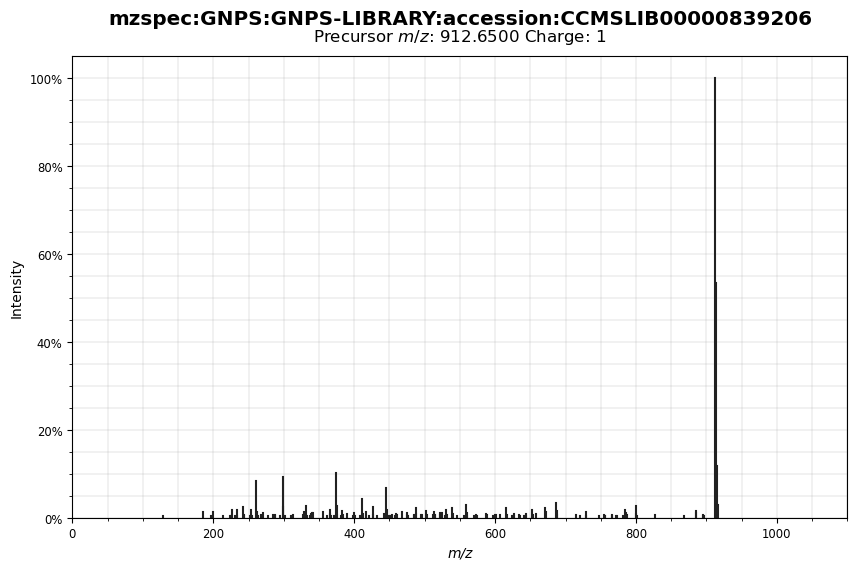

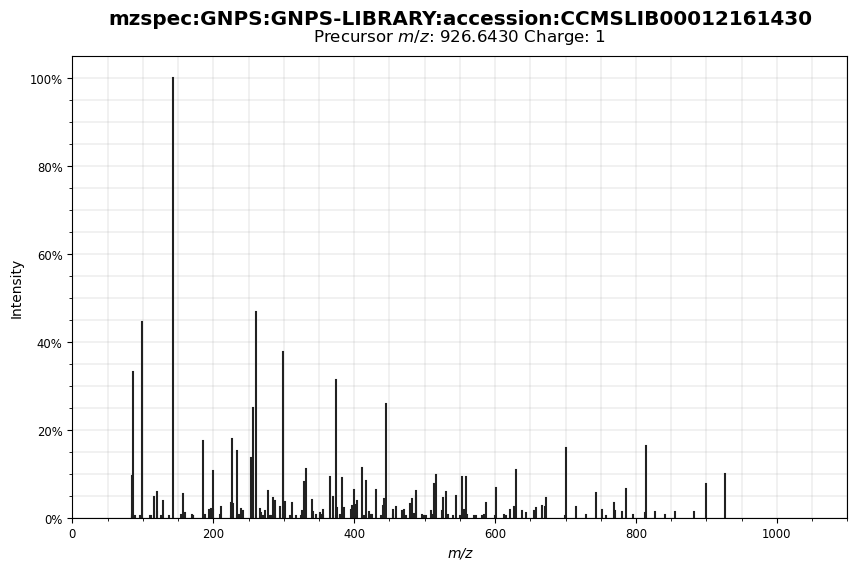

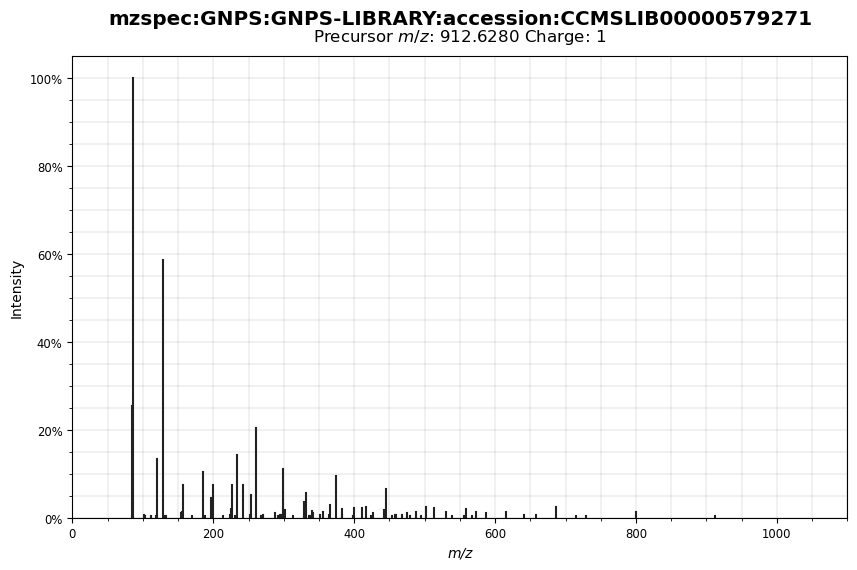

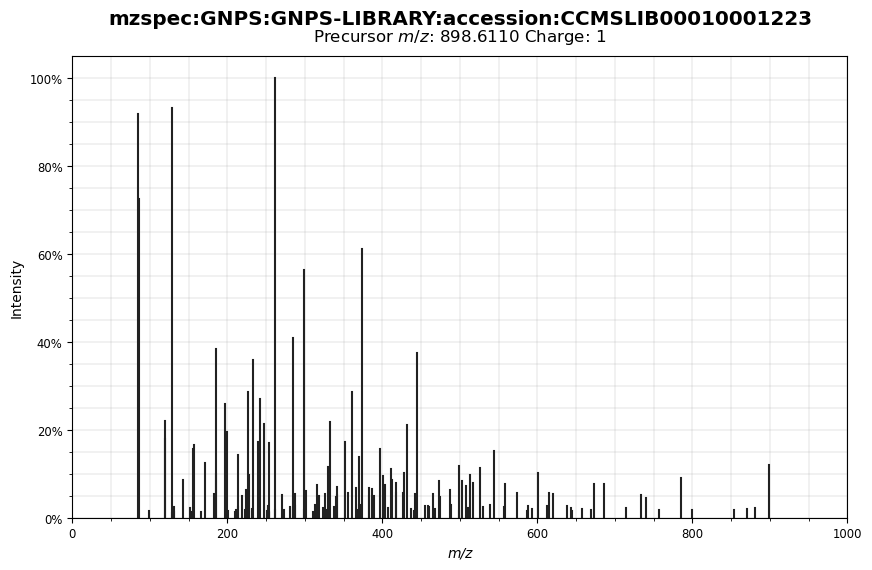

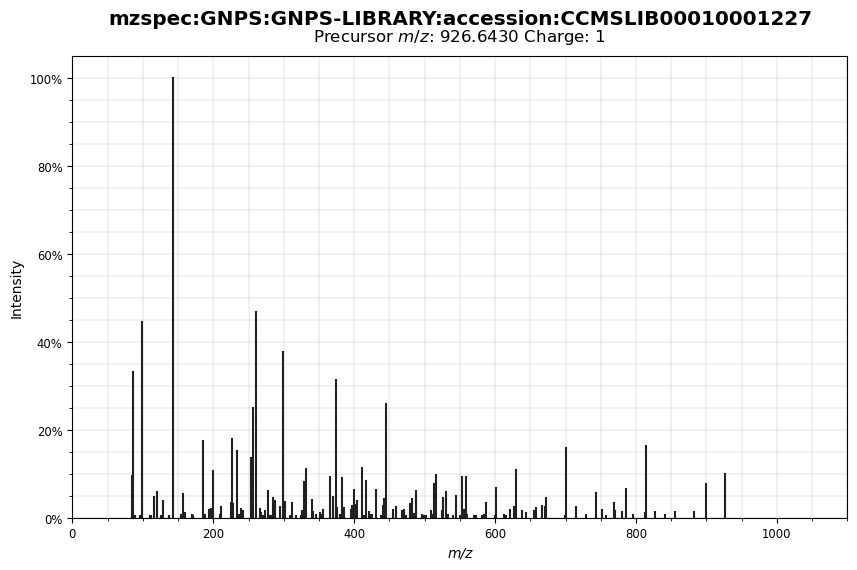

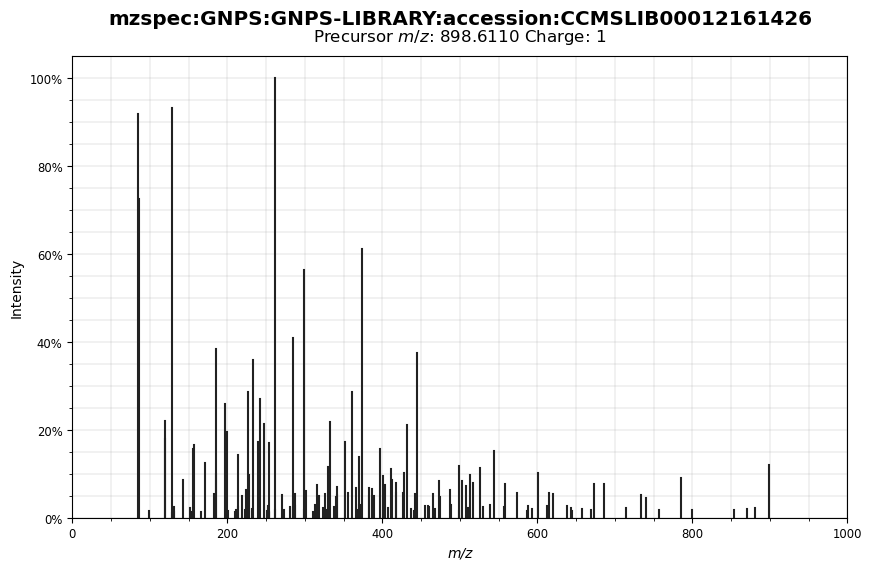

In [4]:
gnps_ids = ['CCMSLIB00000839206',
 'CCMSLIB00012161430',
 'CCMSLIB00000579271',
 'CCMSLIB00010001223',
 'CCMSLIB00010001227',
 'CCMSLIB00012161426']

for i in gnps_ids:
    response = fetch_single_spectrum_image(i)
    if response:
        a = Image(data=response, width=800)
        display(a)
    else:
        print(f"Failed to fetch image for {i}")

In [5]:
@disk_cache()
def fetch_modifinder_alignment(spectrum1, spectrum2, matches='default'):
    try:
        url = f"https://modifinder.gnps2.org/api/visualizer/draw_alignment?spectrums=[%22{spectrum1}%22,%22{spectrum2}%22]&matches={matches}.png"
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        return response.content
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

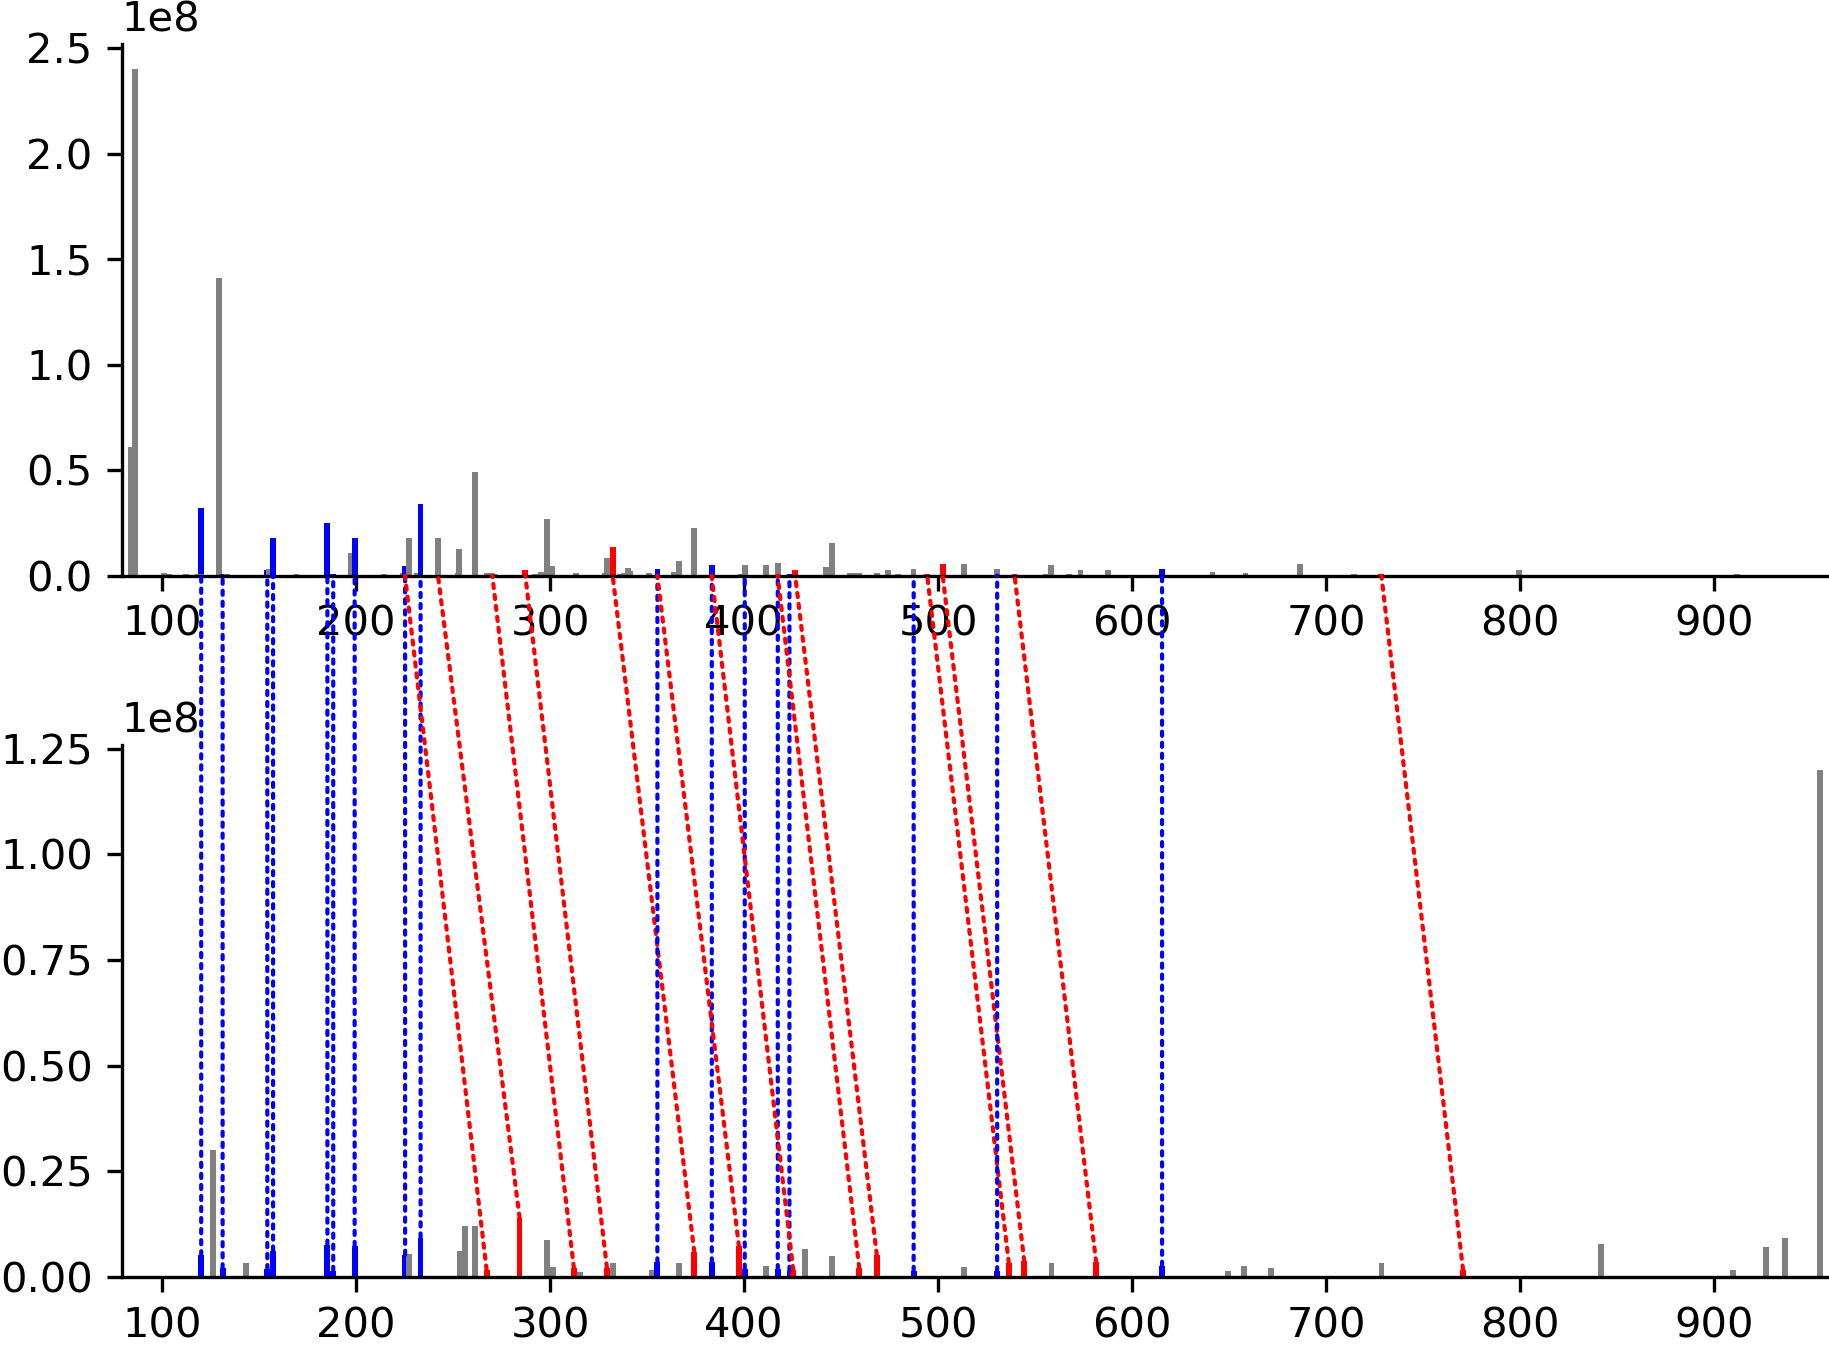

In [6]:
display(
    Image(
        data=fetch_modifinder_alignment("CCMSLIB00000579271", "CCMSLIB00012471599", matches='default'),
        width=500
        )
)

Let's write our own plot function. 

In [7]:
# First we need to get the peaks data from GNPS.

# https://ccms-ucsd.github.io/GNPSDocumentation/usi/

@disk_cache()
def get_peaks_from_gnps(ccmslib_accession=None, usi=None):
    try:
        url = (
            f"https://metabolomics-usi.gnps2.org/json/?usi1=mzspec:GNPS:GNPS-LIBRARY:accession:{ccmslib_accession}"
            if ccmslib_accession else
            f"https://metabolomics-usi.gnps2.org/json/?usi1={usi}"
        )
        response = requests.get(url)
        response.raise_for_status()
        peaks = response.json()['peaks']
        return peaks
    except requests.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [8]:
get_peaks_from_gnps("CCMSLIB00000579271")

[[79.20450592041016, 0.0],
 [79.20516967773438, 0.0],
 [79.20584106445312, 0.0],
 [84.07227325439453, 0.0],
 [84.07300567626953, 0.0],
 [84.07373809814453, 0.0],
 [84.074462890625, 0.0],
 [84.0751953125, 0.0],
 [84.075927734375, 0.0],
 [84.08100891113281, 61064960.0],
 [84.08689880371094, 1202383.625],
 [84.08829498291016, 0.0],
 [84.08902740478516, 0.0],
 [84.08975982666016, 0.0],
 [84.09049224853516, 0.0],
 [86.08783721923828, 0.0],
 [86.08859252929688, 0.0],
 [86.08935546875, 0.0],
 [86.0901107788086, 0.0],
 [86.09693145751953, 240203584.0],
 [86.10376739501953, 0.0],
 [86.10452270507812, 0.0],
 [86.10527801513672, 0.0],
 [86.10604095458984, 0.0],
 [91.96652221679688, 0.0],
 [91.96735382080078, 0.0],
 [91.96819305419922, 0.0],
 [91.96903228759766, 0.0],
 [91.96986389160156, 0.0],
 [91.970703125, 0.0],
 [91.97154235839844, 0.0],
 [91.97237396240234, 0.0],
 [91.97321319580078, 0.0],
 [91.97399139404297, 0.0],
 [91.9748306274414, 0.0],
 [91.97566986083984, 0.0],
 [91.97650146484375, 0.

In [9]:
def plot_ms2_spectrum(peaks1, peaks2=None, width=2, label_top_n=10, max_y=float('inf')):
    """
    Plot an MS2 spectrum or mirror plot using Plotly.
    
    Parameters:
    - peaks1: List of (m/z, intensity) tuples for the first spectrum
    - peaks2: Optional second spectrum for mirror plot
    - width: Line width for the peaks
    - label_top_n: Number of top-intensity peaks in peaks1 to label
    - max_y: Maximum y-axis limit (for positive and negative)
    """
    fig = go.Figure()

    # Filter peaks with positive intensity
    filtered1 = [(x, y) for x, y in peaks1 if y > 0]
    if peaks2:
        filtered2 = [(x, y) for x, y in peaks2 if y > 0]

        # Normalize both spectra to 100 if mirror plot
        max1 = max((y for _, y in filtered1), default=1)
        max2 = max((y for _, y in filtered2), default=1)
        filtered1 = [(x, y / max1 * 100) for x, y in filtered1]
        filtered2 = [(x, y / max2 * 100) for x, y in filtered2]

    # Plot first spectrum (positive axis)
    for x, y in filtered1:
        fig.add_trace(go.Scatter(
            x=[x, x], y=[0, y],
            mode="lines",
            line=dict(color="blue", width=width),
            hoverinfo="text",
            text=[f"m/z: {x:.4f}<br>Intensity: {y:.2f}"] * 2,
            showlegend=False
        ))

    # Label top N peaks in first spectrum (no hover)
    top_peaks = sorted(filtered1, key=lambda p: p[1], reverse=True)[:label_top_n]
    for x, y in top_peaks:
        fig.add_trace(go.Scatter(
            x=[x], y=[y],
            mode="text",
            text=[f"{x:.2f}"],
            textposition="top center",
            hoverinfo="skip",
            showlegend=False
        ))

    # Plot second spectrum as mirror (negative axis)
    if peaks2:
        for x, y in filtered2:
            fig.add_trace(go.Scatter(
                x=[x, x], y=[0, -y],
                mode="lines",
                line=dict(color="red", width=width),
                hoverinfo="text",
                text=[f"m/z: {x:.4f}<br>Intensity: {y:.2f}"] * 2,
                showlegend=False
            ))

    # Determine y-axis range
    max1 = max([y for _, y in filtered1], default=0)
    max2 = max([y for _, y in filtered2], default=0) if peaks2 else 0
    y_max = min(max_y, max(max1, max2) * 1.1)

    # Dynamic y-axis label
    yaxis_label = "Intensity" if not peaks2 else "Intensity (Top) / -Intensity (Bottom)"

    # Layout
    fig.update_layout(
        title="MS2 Spectrum" if not peaks2 else "MS2 Mirror Plot (Normalized)",
        xaxis_title="m/z",
        yaxis_title=yaxis_label,
        yaxis=dict(range=[-y_max, y_max] if peaks2 else [0, y_max]),
        plot_bgcolor="white",
        height=500
    )

    return fig


In [10]:
plot_ms2_spectrum(get_peaks_from_gnps("CCMSLIB00000579271"), width=5, label_top_n=10)

[Cache] Returning cached result for function 'get_peaks_from_gnps'


In [11]:
plot_ms2_spectrum(get_peaks_from_gnps("CCMSLIB00000579271"),get_peaks_from_gnps("CCMSLIB00000579271"), width=5, label_top_n=10)

[Cache] Returning cached result for function 'get_peaks_from_gnps'
[Cache] Returning cached result for function 'get_peaks_from_gnps'


Search for similar spectra in the GNPS library using fasst

In [12]:
# https://wang-bioinformatics-lab.github.io/GNPS2_Documentation/api/#fast-search

r = requests.get("https://fasst.gnps2.org/search?library=gnpsdata_index&usi=mzspec:GNPS:GNPS-LIBRARY:accession:CCMSLIB00000579271")

In [13]:
r.json().keys()


dict_keys(['results', 'timing', 'grouped_by_unit_delta_mass', 'grouped_by_dataset', 'grouped_by_dataset_unit_delta', 'metadata_groupings', 'log'])

In [14]:
len(r.json()['results'])

341

In [15]:
r.json()['results'][0]

{'Delta Mass': 0.0,
 'USI': 'mzspec:MSV000082944:library/GNPS-LIBRARY.mgf:scan:3082',
 'Charge': 1,
 'Cosine': 1.0,
 'Matching Peaks': 18,
 'Unit Delta Mass': 0,
 'Dataset': 'MSV000082944',
 'Status': 'NoID',
 'Query Filename': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/9c4f5495d6124d57a37aefd2e96dc33b.mgf',
 'Query Scan': 1,
 'Index UnitPM': 912,
 'Index IdxInUnitPM': 125500,
 'Filtered Input Spectrum Path': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/0.json'}

In [16]:
r.json()['results'][0]['USI']

'mzspec:MSV000082944:library/GNPS-LIBRARY.mgf:scan:3082'

In [17]:
usi=r.json()['results'][0]['USI']
plot_ms2_spectrum(get_peaks_from_gnps(usi=usi),get_peaks_from_gnps("CCMSLIB00000579271"), width=5, label_top_n=10)

[Cache] Returning cached result for function 'get_peaks_from_gnps'


In [18]:
r.json()['results'][20]

{'Delta Mass': 0.0,
 'USI': 'mzspec:MSV000086314:ccms_peak/Microbes_LCMSMS/P309_LCMSMS.mzML:scan:2432',
 'Charge': 1,
 'Cosine': 0.95,
 'Matching Peaks': 16,
 'Unit Delta Mass': 0,
 'Dataset': 'MSV000086314',
 'Status': 'NoID',
 'Query Filename': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/9c4f5495d6124d57a37aefd2e96dc33b.mgf',
 'Query Scan': 1,
 'Index UnitPM': 912,
 'Index IdxInUnitPM': 121566,
 'Filtered Input Spectrum Path': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/0.json'}

In [19]:
plot_ms2_spectrum(get_peaks_from_gnps(usi=r.json()['results'][20]['USI']),get_peaks_from_gnps("CCMSLIB00000579271"), width=5, label_top_n=10)

[Cache] Returning cached result for function 'get_peaks_from_gnps'


Get full file from GNPS



In [20]:
def download_file(url, local_filename):
    if Path(local_filename).exists():
        raise FileExistsError(f"{local_filename} already exists. Please choose a different name or delete the existing file.")
    # Stream the download to avoid loading the entire file into memory
    with requests.get(url, stream=True) as r:
        r.raise_for_status()  # Check for HTTP errors
        total_size = int(r.headers.get('content-length', 0))
        with open(local_filename, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=81920), total=total_size // 81920, unit='KB'):
                f.write(chunk)
    return local_filename


def resolve_file_from_gnps(usi):
    """
    Resolve a file from GNPS using its USI.
    
    Parameters:
    - usi: The USI of the file to resolve.
    - filename: The name to save the file as.
    Returns:
    - a string url
    
    """
    url = f"https://dashboard.gnps2.org/downloadlink?usi={usi}"
    with requests.get(url) as r:
        r.raise_for_status()
        return r.text

In [21]:
resolve_file_from_gnps(r.json()['results'][20]['USI'])

'https://massiveproxy.gnps2.org/massiveproxy/MSV000086314/ccms_peak/Microbes_LCMSMS/P309_LCMSMS.mzML'

In [22]:
url = resolve_file_from_gnps(r.json()['results'][20]['USI'])
filename = Path(url).name
filename = Path("../data", filename)

download_file(url, filename)

FileExistsError: ../data/P309_LCMSMS.mzML already exists. Please choose a different name or delete the existing file.

In [23]:
!head -n20 '../data/P309_LCMSMS.mzML'

<?xml version="1.0" encoding="utf-8"?>
<indexedmzML xmlns="http://psi.hupo.org/ms/mzml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://psi.hupo.org/ms/mzml http://psidev.info/files/ms/mzML/xsd/mzML1.1.2_idx.xsd">
  <mzML xmlns="http://psi.hupo.org/ms/mzml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://psi.hupo.org/ms/mzml http://psidev.info/files/ms/mzML/xsd/mzML1.1.0.xsd" id="spec-00045" version="1.1.0">
    <cvList count="2">
      <cv id="MS" fullName="Proteomics Standards Initiative Mass Spectrometry Ontology" version="4.1.41" URI="https://raw.githubusercontent.com/HUPO-PSI/psi-ms-CV/master/psi-ms.obo"/>
      <cv id="UO" fullName="Unit Ontology" version="09:04:2014" URI="https://raw.githubusercontent.com/bio-ontology-research-group/unit-ontology/master/unit.obo"/>
    </cvList>
    <fileDescription>
      <fileContent>
        <cvParam cvRef="MS" accession="MS:1000579" name="MS1 spectrum" value=""/>
        <cvPa

For info on mzML see: https://code4np.github.io/posts/intro_to_mass_spec/2_mzml

In [24]:
import pymzml
import os
import pymzml
from pymzml.plot import Factory

mzml_filepath = '../data/P309_LCMSMS.mzML'
run = pymzml.run.Reader(mzml_filepath)


In [25]:
# find ms level 2 where precursors +-.05 of 912.628636
levels = []
for i in run:
    if i.ms_level == 2:
        if abs(i.selected_precursors[0]['mz'] - 912.628636) < 0.15:
            levels.append(i)

In [26]:
[i.index for i in levels]

[2378, 2431, 2483, 2536, 2581, 2630, 2677, 2718, 2763]

In [27]:
levels[0].highestPeaks(10)

array([[  671.766   ,  4511.426   ],
       [  298.21353 ,  6106.551   ],
       [   92.82116 ,  6601.1694  ],
       [  768.88226 , 10839.358   ],
       [  227.1754  , 11272.753   ],
       [  233.16524 , 12831.103   ],
       [  261.15976 , 16294.391   ],
       [  129.10226 , 25294.729   ],
       [   84.081276, 26988.193   ],
       [   86.09689 , 40067.12    ]], dtype=float32)

In [35]:
pd.DataFrame(levels[0].highestPeaks(10), columns=['mz', 'intensity'])

,mz,intensity
0,671.765991,4511.425781
1,298.213531,6106.550781
2,92.821159,6601.169434
3,768.882263,10839.358398
4,227.175400,11272.752930
5,233.165237,12831.102539
6,261.159760,16294.390625
7,129.102264,25294.728516
8,84.081276,26988.193359
9,86.096893,40067.121094


In [28]:
plot_ms2_spectrum(levels[0].centroidedPeaks, get_peaks_from_gnps("CCMSLIB00000579271"))

[Cache] Returning cached result for function 'get_peaks_from_gnps'


In [29]:
r.json()['results'][20]

{'Delta Mass': 0.0,
 'USI': 'mzspec:MSV000086314:ccms_peak/Microbes_LCMSMS/P309_LCMSMS.mzML:scan:2432',
 'Charge': 1,
 'Cosine': 0.95,
 'Matching Peaks': 16,
 'Unit Delta Mass': 0,
 'Dataset': 'MSV000086314',
 'Status': 'NoID',
 'Query Filename': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/9c4f5495d6124d57a37aefd2e96dc33b.mgf',
 'Query Scan': 1,
 'Index UnitPM': 912,
 'Index IdxInUnitPM': 121566,
 'Filtered Input Spectrum Path': 'temp/queries/9c/9c4f5495d6124d57a37aefd2e96dc33b/0.json'}

In [30]:
def get_scan_peaks_by_scan_number(run, scan_id):
    for spectrum in run:
        if spectrum.ID == scan_id:
            return spectrum.centroidedPeaks
    return None

In [31]:
run = pymzml.run.Reader(mzml_filepath)
plot_ms2_spectrum(get_scan_peaks_by_scan_number(run, 2432), get_peaks_from_gnps("CCMSLIB00000579271"))

[Cache] Returning cached result for function 'get_peaks_from_gnps'
